In [1]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
from local_models.plotting_utils import mayavi_plt_pts
from local_models.tf_quadric_models import *
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import mayavi
import mayavi.mlab
import string
import subprocess
import functools
import cv2
import itertools
from local_models.quadric_models import *
from local_models.plotting_utils import *
import joblib


#on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
mayavi.mlab.options.offscreen = True



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
FRESH=True

In [3]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [4]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [5]:
data = np.loadtxt("../data/bunny/bunny/data/bun.csv")

In [6]:
data.shape

(362272, 3)

In [7]:
np.std(data,axis=0)

array([0.04234508, 0.03921931, 0.02899566])

In [8]:
#scale the data.... having underflow errors
data = data*1/np.min(np.std(data, axis=0))

In [9]:
np.std(data,axis=0)

array([1.46039349, 1.35259215, 1.        ])

In [10]:
KERNEL=local_models.local_models.TriCubeKernel
RUN = 13
subsample_rate = 0.005
K=120

project_dir = "../data/bunny_iterated_local_quadric_regression_{}_{:03d}".format(kernel_names[KERNEL], RUN)

os.makedirs(project_dir, exist_ok=1)

In [11]:
np.random.seed(0)
subsampled_bunny_indices = np.random.choice(np.arange(data.shape[0]), size=int(subsample_rate*data.shape[0]), replace=False)
subsampled_bunny = data[subsampled_bunny_indices]
subsampled_bunny.shape

(1811, 3)

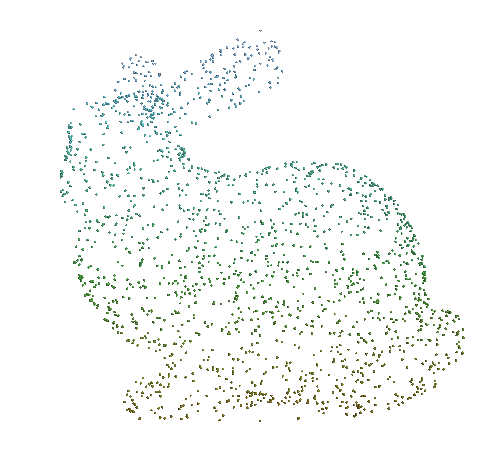

In [12]:
mayavi_plt_pts(subsampled_bunny)

In [13]:
very_subsampled_bunny_indices = np.random.choice(np.arange(data.shape[0]), size=int(subsample_rate/10*data.shape[0]), replace=False)
very_subsampled_bunny = data[very_subsampled_bunny_indices]
very_subsampled_bunny.shape

(181, 3)

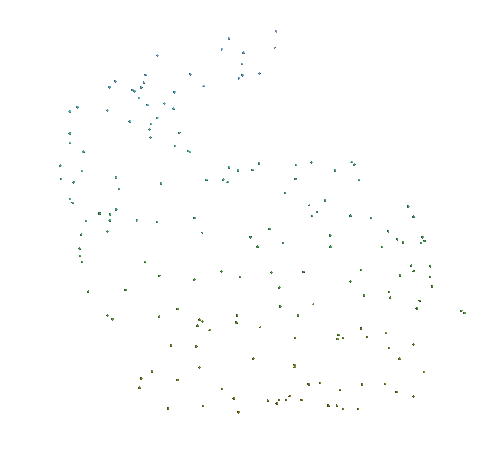

In [14]:
mayavi_plt_pts(very_subsampled_bunny)

In [15]:
def project_and_tf_plt(x, q, pth, additional_pts=[], colormaps=None):
    import tensorflow as tf
    import tf_roots
    import quadrics_utils

    projection_funcs = {
        "k_mat": quadrics_utils.k_mat,
        "other_dims_as_x": lambda a,b,c,d,e,f,g,x: [quadrics_utils.y_as_x(a,b,c,d,e,f,g,x), quadrics_utils.z_as_x(a,b,c,d,e,f,g,x)],
    }
    with tf.Graph().as_default(), tf.Session() as sess:
        test_qs = tf.placeholder(tf.float32, q.shape)
        test_pts = tf.placeholder(tf.float32, x.shape)
        test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
        test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
        tf_projected_pts, _ = tf_ortho_project(test_qsc, test_pts)
        projected_pts = sess.run(tf_projected_pts, feed_dict={test_qs:q, test_pts:x})
    mayavi_plt_pts([projected_pts]+additional_pts, pth, False, 
        np.average(x,axis=0), np.std(x,axis=0), False, colormaps=colormaps)

In [16]:
def project_and_plt(x, q, pth, additional_pts=[], colormaps=None):
    projected_pts, _ = orthogonal_quadric_projection(x,q,projection_funcs)
    mayavi_plt_pts([projected_pts]+additional_pts, pth, False, 
        np.average(x,axis=0), np.std(x,axis=0), 
        #None, None,
        False, colormaps=colormaps)

In [17]:
def fq2q(fq,input_shape=3):
    return fq + fq.T - np.diag(fq[np.diag_indices(input_shape+1)])

In [18]:
def flatq2q(fq, input_shape=3):
    q = np.zeros((input_shape+1,input_shape+1))
    q[np.triu_indices(input_shape+1)] = fq
    q = q + q.T - np.diag(q[np.diag_indices(input_shape+1)])
    return q

In [19]:
regular_parabolic_projection_funcs_3, special_parabolic_projection_funcs_3 = arrange_parabolic_projection_funcs(3)

In [20]:
with fuckit("nothing to del"):
    TFQuadricSesh.close()
with fuckit("nothing to del"):
    del TFQuadricSesh 
with fuckit("nothing to del"):
    del TFQuadricGraph 
with fuckit("nothing to del"):
    del local_models.tf_quadric_models.TFQuadricSesh
with fuckit("nothing to del"):
    del local_models.tf_quadric_models.TFQuadricGraph

nothing to del
nothing to del
nothing to del
nothing to del
nothing to del


In [21]:
parabolic_model = TFParabolic(n_epochs=5000, log_epochs=True, weighted=True, parabolic_constraint=True, 
    learning_rate=.02, input_shape=3, normalize_weights=True, loss_trim=0.95,
    projection_funcs = (regular_parabolic_projection_funcs_3, special_parabolic_projection_funcs_3))
parabolic_model = TFParabolic(n_epochs=5000, log_epochs=True, weighted=True, parabolic_constraint=True, 
    learning_rate=.02, input_shape=3, normalize_weights=True, loss_trim=0.95,
    projection_funcs = (regular_parabolic_projection_funcs_3, special_parabolic_projection_funcs_3),
    model = parabolic_model.model)
local_quadrics = local_models.local_models.LocalModels(parabolic_model)
local_quadrics.fit(data)

building!
Tensor("quadric_regression/quadric_projection/transpose_1:0", shape=(3, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_1:0", shape=(?, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_2:0", shape=(1, 3), dtype=complex128)
L,U,UL,UR,BR Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_2:0", shape=(3, 3), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_2:0", shape=(?, 3), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_4:0", shape=(?, 1), dtype=complex128)
args0 Tensor("quadric_regression/quadric_projection/cond/strided_slice_2:0", shape=(?, 1), dtype=complex128)
(?, 1)
args1 Tensor("quadric_regression/quadric_projection/cond/strided_slice_3:0", shape=(?, 1), dtype=complex128)
(?, 1)
args2 Tensor("quad

special_pts Tensor("quadric_regression/quadric_projection/cond_1/Merge:0", shape=(?, 3), dtype=complex128)
Tensor("quadric_regression/training/optimizer/update_quadric_regression/quadric_projection/flattened_quadric/parabolic_constraint/GatherV2_1:0", shape=(3,), dtype=float64)
Tensor("quadric_regression/training/optimizer/update_quadric_regression/quadric_projection/flattened_quadric/parabolic_constraint/concat_3:0", shape=(3,), dtype=float64)
(4, 4)


In [22]:
parabolic_model.model.grads

[(<tf.Tensor 'quadric_regression/training/gradients/quadric_regression/quadric_projection/map/while/strided_slice/Enter_grad/b_acc_3:0' shape=(10,) dtype=float64>,
  <tf.Variable 'quadric_regression/quadric_projection/flattened_quadric:0' shape=(10,) dtype=float64_ref>)]

In [23]:
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth="knn", k=K)

In [24]:
def local_odq_shift(quadric_models, data, iterations=100, kernel=None, batch_size=100):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=iterations, tag="local_odq_shift")

    yield data
    for i in range(iterations):
        print(i)
        with timelog:
            if hasattr(kernel.bandwidth, "__call__"):
                data = quadric_models.predict(data,
                    k=kernel.k, weighted=True, kernel=kernel,
                    neighbor_beta0s=False, batch_size=batch_size, parallel=True)
            else:
                data = quadric_models.predict(data,
                    r=kernel.support_radius(), weighted=True, kernel=kernel,
                    neighbor_beta0s=False, batch_size=batch_size, parallel=True)
            yield data


In [25]:
def reduce_epochs_model_updater(m,rate=0.9):
    m.epochs = int(m.epochs*rate)
    return m
def epoch_schedule_model_updater(m,schedule=None):
    #takes in an infinite generator that updates the epochs
    if schedule is None:
        raise Exception("you need an epoch schedule.  No sense in beginning training cause it's all gonna explode in a little while")
    next_epoch_level = next(schedule)
    m.epochs = next_epoch_level
    return m
    
def local_odq_shift_unfitted(unfitted_quadric_models, fit_data, predict_data, 
    iterations=100, kernel=None, batch_size=None, previous_beta0=False, model_updater=None, return_params=False):
    
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=iterations, tag="local_odq_shift")

    if batch_size is None:
        batch_size = predict_data.shape[0]
        
    if hasattr(kernel.bandwidth, "__call__"):
        radius_kwargs = {"k":kernel.k}
    else:
        radius_kwargs = {"r":kernel.support_radius()}

    beta0 = None

    fitted_quadric_models = unfitted_quadric_models.fit(fit_data)
    iterated_predictions = [predict_data]
    iterated_beta0 = []

    for i in range(iterations):
        with timelog:
            try:
                if previous_beta0 or return_params:
                    model_postprocessor = lambda m,q,x,y,w: np.concatenate((m.predict(q), local_models.local_models.get_learned_param_vector(m)), axis=1)
                    predict_data_cat_params = fitted_quadric_models.transform(predict_data,
                        weighted=True, kernel=kernel, neighbor_beta0s=False, 
                        batch_size=batch_size, model_postprocessor=model_postprocessor, beta0=beta0,
                        **radius_kwargs)
                    predict_data = predict_data_cat_params[:,:predict_data.shape[1]]
                    if previous_beta0:
                        beta0 = predict_data_cat_params[:,predict_data.shape[1]:]
                    if return_params:
                        iterated_beta0.append(predict_data_cat_params[:,predict_data.shape[1]:])
                else:
                    predict_data = fitted_quadric_models.predict(predict_data,
                        weighted=True, kernel=kernel, neighbor_beta0s=False, 
                        batch_size=batch_size, **radius_kwargs)
            except:
                logger.info("local model FAILED! {}".format(str(fitted_quadric_models.model.sess.run(fitted_quadric_models.model.model.q))))

            iterated_predictions.append(predict_data)
            if model_updater is not None:
                unfitted_quadric_models.model = model_updater(unfitted_quadric_models.model)
    # returns data in [n_pts, n_features, n_iterations] shape
    if return_params:
        return np.stack(iterated_predictions, axis=-1), np.stack(iterated_beta0, axis=-1)
    return np.stack(iterated_predictions, axis=-1)

In [26]:
def local_odq_shift_parallel(unfitted_quadric_models, fit_data, predict_data, 
    iterations=100, kernel=None, batch_size=100, n_jobs=32, previous_beta0=False, model_updater=None, return_params=False):
    
    base_batch = np.array([0,batch_size])
    n_batches = predict_data.shape[0]/batch_size

    slicers = [slice(*(base_batch + batch_size*n)) for n in range(int(np.ceil(n_batches)))]

    iterated_predictionses = joblib.Parallel(n_jobs=n_jobs, verbose=100)(joblib.delayed(local_odq_shift_unfitted)(
                unfitted_quadric_models,
                fit_data,
                predict_data[slicer],
                iterations=iterations,
                kernel=kernel,
                previous_beta0=previous_beta0,
                model_updater=model_updater,
                return_params=return_params
            )
            for slicer in slicers
        )
    logger.info("finished")
    return iterated_predictionses
    #all_predictions = np.concatenate(iterated_predictionses, axis=0)
    #return 0
    #return all_predictions


In [27]:
N_JOBS = 24
#from dask.distributed import Client
#client = Client('tcp://localhost:8786')
with joblib.parallel_backend('loky'):
    odq_shift_iterations = local_odq_shift_parallel(local_quadrics, data, very_subsampled_bunny, 
        iterations=40, kernel=lm_kernel, batch_size=int(np.ceil(very_subsampled_bunny.shape[0]/N_JOBS)), 
        n_jobs=N_JOBS, return_params=True)

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
Memmapping (shape=(362272, 3), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_3732_9744900565/3732-139715465952392-4bbeb2faaa0148a79bf3b9c52292fe83.pkl
Memmapping (shape=(362272,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_3732_9744900565/3732-139715465952392-a79f4a3ed02548f9afa6f97e34537b60.pkl
Pickling array (shape=(16383,), dtype=[('idx_start', '<i8'), ('idx_end', '<i8'), ('is_leaf', '<i8'), ('radius', '<f8')]).
Pickling array (shape=(1, 16383, 3), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(1, 1), dtype=float64).
Pickling array (shape=(10,), dtype=float64).
Pickling array (shape=(8, 3), dtype=float64).
Memmapping (shape=(362272, 3), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_3732_9744900565/3732-139715465952392-4bbeb2faaa0148a79bf3b9c52292fe83.pkl
Memmapping (shape=(362272,), dtype=int64) to old file /dev/shm/joblib_mem

Pickling array (shape=(10,), dtype=float64).
Pickling array (shape=(8, 3), dtype=float64).
Memmapping (shape=(362272, 3), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_3732_9744900565/3732-139715465952392-4bbeb2faaa0148a79bf3b9c52292fe83.pkl
Memmapping (shape=(362272,), dtype=int64) to old file /dev/shm/joblib_memmapping_folder_3732_9744900565/3732-139715465952392-a79f4a3ed02548f9afa6f97e34537b60.pkl
Pickling array (shape=(16383,), dtype=[('idx_start', '<i8'), ('idx_end', '<i8'), ('is_leaf', '<i8'), ('radius', '<f8')]).
Pickling array (shape=(1, 16383, 3), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(1, 1), dtype=float64).
Pickling array (shape=(10,), dtype=float64).
Pickling array (shape=(8, 3), dtype=float64).
Memmapping (shape=(362272, 3), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_3732_9744900565/3732-139715465952392-4bbeb2faaa0148a79bf3b9c52292fe83.pkl
Memmapping (shape=(362272,), dtype=int64) to old file /dev/

KeyboardInterrupt: 

In [ ]:
len(odq_shift_iterations[0])

In [ ]:
odq_shift_predictions = np.concatenate([sol[0] for sol in odq_shift_iterations], axis=0)
odq_shift_params = np.concatenate([sol[1] for sol in odq_shift_iterations], axis=0)

In [ ]:
odq_shift_predictions.shape

In [ ]:
odq_shift_params.shape

In [ ]:
shift_distances = np.sum(np.diff(odq_shift_predictions, axis=2)**2, axis=1)
shift_distances.shape

In [ ]:
max_shift_index = np.unravel_index(np.argmax(shift_distances), shift_distances.shape)
max_shift_index

In [ ]:
shift_distances[max_shift_index]

In [ ]:
odq_shift_predictions[max_shift_index[0],:,max_shift_index[1]]

In [ ]:
odq_shift_predictions[max_shift_index[0],:,max_shift_index[1]+1]

In [ ]:
odq_shift_params[max_shift_index[0],:,max_shift_index[1]]

In [ ]:
odq_shift_params[max_shift_index[0],:,max_shift_index[1]-8]

In [ ]:
fig, axes = plt.subplots(odq_shift_params.shape[1])
for i in range(odq_shift_params.shape[1]):
    axes[i].plot(odq_shift_params[max_shift_index[0],i,:])

In [ ]:
import local_models.linear_projections
import local_models.utils

def animate(data, c, iterations, pth, range_pct=0.1):
    data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(data)
    graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

    for i,projections in enumerate(iterations):
        figure = plt.figure()
        plt.scatter(data[:,0], data[:,1],c=cmap(c))
        plt.scatter(projections[:,0], projections[:,1],c='r',s=0.1)
        plt.title("iteration_{:05d}".format(i))
        plt.xlim(graph_bounds[:,0])
        plt.ylim(graph_bounds[:,1])
        plt.savefig(os.path.join(pth, "iteration_{:05d}.png".format(i)))

def mayavi_animate(data, iterations, pth, focus=None, dist=None):
    for i, projections in enumerate(iterations):
        filename = os.path.join(pth, "iteration_{:05d}.png".format(i))
        if data is not None:
            mayavi_plt_pts([data, projections], filename, dist=dist, focus=focus)
        else:
            mayavi_plt_pts([projections], filename, dist=dist, focus=focus)


In [ ]:
animate_dir = os.path.join(project_dir, "animate_iterations_parallel")
os.makedirs(animate_dir, exist_ok=1)

In [ ]:
%%capture
mayavi_animate(None, odq_shift_predictions.transpose(2,0,1), animate_dir, 
    focus=np.mean(subsampled_bunny, axis=0), dist=np.std(subsampled_bunny, axis=0))

In [ ]:
odq_shift_predictions[...,-1] - very_subsampled_bunny

In [ ]:
worst = np.argmax(np.sum((odq_shift_predictions[...,-1] - very_subsampled_bunny)**2,axis=-1))
worst

In [ ]:
(odq_shift_predictions[...,-1] - very_subsampled_bunny)[worst]

In [ ]:
def np_arrange_parabolic_projection_funcs(n):
    import importlib
    import subprocess
    try:
        importlib.import_module("parabolic_utils_{}".format(n))
    except ImportError:
        subprocess.call(["python3","-m","local_models.quadric_models","--parabolic","{}".format(n)])
    projection_funcs = importlib.import_module("parabolic_utils_{}".format(n))
    parabolic_projection_funcs = {
        "k_mat": getattr(projection_funcs, "k_mat0_{}".format(n)),
        "other_dims_as_x": getattr(projection_funcs, "other_dims_as_x0_{}".format(n))
    }
    return parabolic_projection_funcs

In [ ]:
def np_arrange_quadric_projection_funcs(n):
    import importlib
    import subprocess
    projection_funcs = importlib.import_module("local_models.quadrics_utils_{}".format(n))
    quadric_projection_funcs = {
        "k_mat": getattr(projection_funcs, "k_mat_{}".format(n)),
        "other_dims_as_x": getattr(projection_funcs, "other_dims_as_x_{}".format(n))
    }
    return quadric_projection_funcs